In [74]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import resampy

In [75]:
# old method for loading audio
def audio_to_spectrogram(audio_file, output_dir):
    # Load the audio file
    audio, sr = librosa.load(
        audio_file, sr=None
    )  # sr=None preserves the original sampling rate

    # Create the spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Set the file name for the spectrogram
    fname = os.path.basename(audio_file).rsplit(".")[0] + ".png"
    spectrogram_file = os.path.join(output_dir, fname)

    # Plot and save the spectrogram as an image
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
    librosa.display.specshow(S_dB)
    plt.savefig(spectrogram_file, bbox_inches="tight", pad_inches=0)
    plt.close()

    return spectrogram_file

In [76]:
from transformers import WhisperFeatureExtractor


# https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-i-3f5400bbbcd8
# reasoning behind feature size of 13 (or 20)

N_MELS = 20

class CustomWhisperFeatureExtractor(WhisperFeatureExtractor):
    def __init__(self, n_mels=N_MELS, **kwargs):
        super().__init__(feature_size=n_mels, **kwargs)


feature_extractor = CustomWhisperFeatureExtractor(
    n_mels=N_MELS, sampling_rate=16000, padding_value=0.0, return_attention_mask=False
)

In [77]:
# based on https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb
# see https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-i-3f5400bbbcd8
# for choice of features (13 or 20)
def mp3_to_img(path, min_length=0.0, max_length=20.0, n_mels=N_MELS):
    signal, sr = librosa.load(path)
    signal = resampy.resample(signal, sr_orig=sr, sr_new=16000, res_type="kaiser_fast")
    # hl = signal.shape[0] // (width * 1.1)  # Cut away 5% from start and end

    duration = librosa.get_duration(y=signal, sr=16000)
    if duration < min_length or duration > max_length:
        # print(f"Skipping {path} due to length {duration}")
        return None, None

    f = feature_extractor(
        signal,
        sampling_rate=16000,
        padding="max_length", # pads to 30 seconds
        do_normalize=True,
        feature_size=n_mels,
        return_attention_mask=False,
        # hop_length=hl,
    )
    # [print(k, v[0].shape) for k, v in f.items()]

    # spec = librosa.feature.melspectrogram(y=signal, n_mels=height, hop_length=int(hl))
    input_features = np.array(f["input_features"])[0]
    # truncate to width of 1000
    # print(input_features.shape)
    input_features = input_features[:, :1000]

    fname = os.path.basename(path).rsplit(".")[0]
    return input_features, fname


# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349
def save_spec(spec, out):
    # min-max scale to fit inside 8-bit range
    spec = scale_minmax(spec, 0, 255).astype(np.uint8)
    img = np.flip(spec, axis=0)  # put low frequencies at the bottom in image
    # img = 255 - img  # invert. make black==more energy

    # save with PIL
    # display(Image.fromarray(img))
    Image.fromarray(img).save(out)

/var/folders/m9/9vx0zm4904qdn2jzwc0shtpm0000gn/T/ipykernel_25354/12447177.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path)
/Users/thabnir/maisproj/.venv/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/Users/thabnir/maisproj/audiotospect.py:48: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(audiopath, res_type="kaiser_fast")
/Users/thabnir/maisproj/.venv/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/Users/thabnir/maisproj/audiotospect.py:48: UserWarning: PySoundFile failed. Trying a

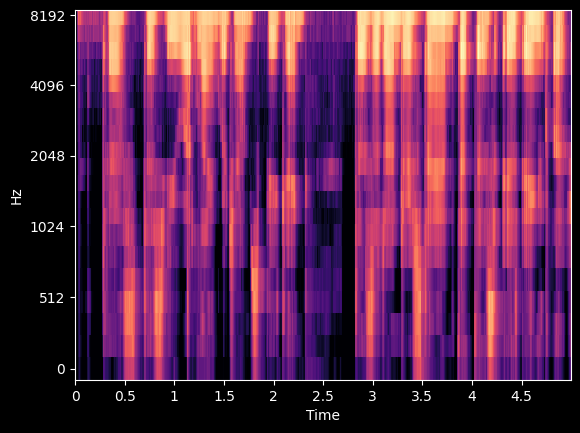

In [78]:
import audiotospect

file = "data/mp3/en/common_voice_en_604929.mp3"
file2 = "data/mp3/fr/common_voice_fr_17301086.mp3"
file3 = "data/mp3/en/common_voice_en_25282.mp3"

old_version, fname = mp3_to_img("./flask/temp/recording.webm")
new_version = audiotospect.audio_to_spect(
    "./flask/temp/recording.webm",
    # file,
    target_size=(13, 500),
    img_dimensions=(13, 500, 1),
    save=False,
)
new_version_2 = audiotospect.audio_to_spect(
    "./flask/temp/recording.webm",
    # file,
    target_size=(20, 500),
    img_dimensions=(20, 500, 1),
    save=False,
)

librosa.display.specshow(
    new_version_2, x_axis="time", y_axis="mel", sr=16000, hop_length=160
)

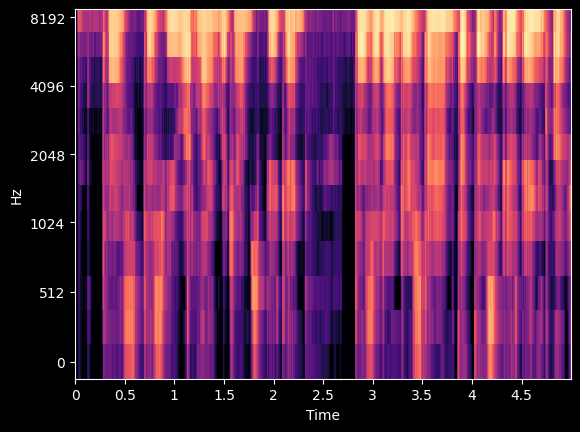

In [79]:
librosa.display.specshow(new_version, x_axis="time", y_axis="mel", sr=16000, hop_length=160) 
# librosa.display.specshow(
#     old_version,
#     x_axis="time",
#     y_axis="mel",
#     sr=feature_extractor.sampling_rate,
#     hop_length=feature_extractor.hop_length,
# )

In [80]:
MIN_DURATION_IN_SECONDS = 4.0
MAX_DURATION_IN_SECONDS = 9.0

import random


def get_valid_lengths(input_dir):
    if not os.path.exists(input_dir):
        print("Input directory does not exist.")
        return

    files = os.listdir(input_dir)
    lengths = []
    random.shuffle(files)
    # files = files[:1000]
    num_removed = 0
    num_files = len(files)
    for file in tqdm(files):
        if file.endswith(".mp3"):
            audio_file = os.path.join(input_dir, file)
            length = librosa.get_duration(filename=audio_file)
            if length > MIN_DURATION_IN_SECONDS and length < MAX_DURATION_IN_SECONDS:
                lengths.append(length)
            else:
                print(f"File {file} has length {length}.")
                num_removed += 1

    print(f"Removed {num_removed} files out of {num_files} files.")
    # equitvalent in pct:
    print(f"Removed {num_removed/num_files*100:.2f}% of files.")
    return lengths

In [81]:
def make_spects(
    input_dir,
    output_dir,
    num_files=100,
    shuffle=True,
    offset=0,
    min_length=MIN_DURATION_IN_SECONDS,
    max_length=MAX_DURATION_IN_SECONDS,
):
    # TODO: make it auto-detect files that have already been converted and skip them
    # so this script can be run multiple times to add more files
    if not os.path.exists(input_dir):
        print("Input directory does not exist.")
        return

    os.makedirs(output_dir, exist_ok=True)

    files = os.listdir(input_dir)
    if shuffle:
        np.random.shuffle(files)

    already_converted = os.listdir(output_dir)
    # take intersection of files and already_converted
    already_converted = set([f.rsplit(".")[0] for f in already_converted])
    print(len(already_converted))
    # subtract
    files = [f for f in files if f.rsplit(".")[0] not in already_converted]
    print(f"Converting {len(files)} files.")
    # note: this doesn't work for files that have been read and found to be too long or too short
    # and thus skipped
    # those will be re-measured, re-determined to be too long or too short, and skipped again
    # there are ~7000 of those per language...
    # oh well
    # could keep track of which files have been skipped previously and skip them again but whatever


    files = files[offset : num_files + offset]
    # files = files[:num_files]
    print(f"Converting {len(files)} files.")

    lengths = []
    for file in tqdm(files):
        if file.endswith(".mp3"):
            audio_file = os.path.join(input_dir, file)
            img, fname = mp3_to_img(path=audio_file, min_length=min_length, max_length=max_length)
            if img is not None:
                lengths.append(img.shape[1])
                save_spec(img, os.path.join(output_dir, fname) + ".png")
            # print(img.shape)
            # lengths.append(img.shape[1])
            # convert to rgb using PIL
            # img = Image.fromarray(img[0])
            # display(img.convert("RGB"))
            # img.save(os.path.join(output_dir, fname) + ".png")
    return lengths # measured in number of timesteps (width of image)

# current data used: <lang>_train_0, <lang>_train_1, <lang>_train_10
# don't know why they skip 2-9 but whatever, they're not on huggingface
# except for italian and spanish, which have <lang>_train_0, <lang>_train_1, <lang>_train_2

# langs = ["ar", "de", "en", "es", "fr", "hi", "it", "ja", "ru", "zh-CN"]

In [82]:

langs = ["de", "en", "es", "fr", "it"]

for lang in langs:
    input_dir = f"data/mp3/{lang}/"
    output_dir = f"data/spectrogram/{lang}_train_{N_MELS}_mels/"
    print(f"Converting mp3 files in `{input_dir}` to spectrograms in `{output_dir}`")
    lens = make_spects(
        input_dir,
        output_dir,
        num_files=120_000,
        shuffle=False,
        offset=0, # adding new files to the previously converted 20,000 ignoring previously converted files
        min_length=MIN_DURATION_IN_SECONDS,
        max_length=MAX_DURATION_IN_SECONDS,
    )
    # lens = get_valid_lengths(input_dir)
    lens = np.array(lens)
    # print(f"Average length: {np.mean(lens)}")
    # print(f"Max length: {np.max(lens)}")
    # print(f"Min length: {np.min(lens)}")

Converting mp3 files in `data/mp3/de/` to spectrograms in `data/spectrogram/de_train_20_mels/`
0
Converting 120000 files.
Converting 120000 files.


100%|██████████| 120000/120000 [3:26:18<00:00,  9.69it/s]  


Converting mp3 files in `data/mp3/en/` to spectrograms in `data/spectrogram/en_train_20_mels/`
0
Converting 120000 files.
Converting 120000 files.


100%|██████████| 120000/120000 [2:25:17<00:00, 13.77it/s] 


Converting mp3 files in `data/mp3/es/` to spectrograms in `data/spectrogram/es_train_20_mels/`
0
Converting 120000 files.
Converting 120000 files.


100%|██████████| 120000/120000 [1:59:01<00:00, 16.80it/s] 


Converting mp3 files in `data/mp3/fr/` to spectrograms in `data/spectrogram/fr_train_20_mels/`
0
Converting 120000 files.
Converting 120000 files.


100%|██████████| 120000/120000 [2:09:22<00:00, 15.46it/s] 


Converting mp3 files in `data/mp3/it/` to spectrograms in `data/spectrogram/it_train_20_mels/`
0
Converting 120000 files.
Converting 120000 files.


100%|██████████| 120000/120000 [2:11:45<00:00, 15.18it/s] 


In [83]:
# # measure length of spectrograms
# def get_spect_width(path):
#     img = Image.open(path)
#     return img.size[0]    
    

# # langs2 = ["en", "de"]
# lengths = []
# i = 0
# for lang in langs:
#     input_dir = f"data/spectrogram/{lang}_train_new/"
#     lengths.append([])
#     for file in tqdm(os.listdir(input_dir)):
#         if file.endswith(".png"):
#             path = os.path.join(input_dir, file)
#             width = get_spect_width(path)
#             lengths[i].append(width)
    
#     lens = np.array(lengths[i])
#     print(f"Average length: {np.mean(lens)}")
#     print(f"Max length: {np.max(lens)}")
#     print(f"Min length: {np.min(lens)}")
#     i += 1
# # get average length
# # get max length
# # get min length

